In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta


from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Pycaret을 이용한 튜닝 및 예측
 - 3 표준편차 기준 이상치 대체 반응변수
 - 왜도 3 이상 값들 로그변환 설명변수
 - VIF < 11 인 값들
 - 부스팅 / 배깅 / 블랜딩 3개 혼합모델

#### 0. 데이터 불러오기
- stepwise로 선택된 변수
- 이상치가 대체된 배출량 data

In [2]:
data = pd.read_csv("행정동2 군집의 data 이상치 3.csv")
variable_dummy = np.load("행정동2 VIF10 선택변수.npy")

성능평가 방법
- RMSLE

In [3]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def eval_reg(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:,.3f}".format(rmsle_val,rmse_val,mae_val))
    return rmsle_val,rmse_val,mae_val

#### 1. 데이터 생성하기
- 로그변환

In [4]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data["내국인_목적별 0 친지방문"] = std.fit_transform(data["내국인_목적별 0 친지방문"].values.reshape(-1,1))

In [5]:
Y = data["배출량"]
    
dummy = pd.get_dummies(data[["년","월","일","요일","분기"]],columns = ["년","월","일","요일","분기"]).columns
variable_nodummy = list(set(variable_dummy).difference(dummy))
# stepwise로 선택된 변수 중 dummy가 아닌 것들
    
select_dummy = list(set(variable_dummy).difference(variable_nodummy))
# stepwsie로 선택된 변수 중 dummy인 변수들
    
X_1 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[variable_nodummy]
# X_1 : 더미변수를 제하고 stepwise로 선택된 모든 변수 dataframe

X_2 = pd.get_dummies(data.drop(["일자","행정시","배출량","행정동명"],axis=1)
                         ,columns=["년","월","일","요일","분기"])[select_dummy]
# X_2 : stepwise로 선택된 모든 더미변수 dataframe

loglist=[]
# 왜도 3인 설명변수 log1p 변환
for val in list(X_1.columns):
    if abs(X_1[val].skew())>3:
        X_1[val] = np.log1p(X_1[val])
        loglist.append(val)
        
X_1 = pd.DataFrame(X_1)
    
X_3 = data["행정동명"]
# Categorical Features인 행정동명
    
X = pd.concat([X_1,X_2,X_3],axis=1)
# X1, X2, X3 데이터 concat


x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

reg = setup(data=train,
                target='배출량',
                numeric_imputation = 'mean',
                normalize = True,
                normalize_method = 'zscore',
                categorical_features = ["행정동명"],
                silent= True,
                fold_strategy = 'timeseries',
                fold = 3,
                session_id = 0,
                verbose=False)
print(loglist)

['일강수량', '단기1방문표준편차', '연휴다음날', '연말']


단일 모델 선택하기 위한 성능 비교

In [118]:
best_5_d = compare_models(sort = 'RMSLE', n_select = 5)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,154636.2851,50818334923.8236,224888.3072,0.9001,0.1897,0.1397,0.1733
gbr,Gradient Boosting Regressor,163993.8302,51282601274.6193,226390.2510,0.8989,0.1944,0.1477,0.1300
lightgbm,Light Gradient Boosting Machine,162891.5642,53211814615.7096,230596.5257,0.8952,0.1969,0.1475,0.4500
rf,Random Forest Regressor,163120.7339,53161770450.6448,230361.5686,0.8953,0.1986,0.1483,0.2433
knn,K Neighbors Regressor,200201.8958,83827382954.6667,285761.0104,0.8360,0.2355,0.1822,0.0233
huber,Huber Regressor,207302.6842,75300233380.8083,273705.3337,0.8521,0.2397,0.1873,0.0233
ridge,Ridge Regression,176774.6302,56711412394.6667,238091.0781,0.8881,0.2405,0.1668,1.1233
llar,Lasso Least Angle Regression,176047.1839,56520810971.9796,237689.8179,0.8885,0.2435,0.1667,0.0233
lr,Linear Regression,176048.1823,56521359360.0000,237690.8646,0.8885,0.2436,0.1667,1.8967
lasso,Lasso Regression,176047.6042,56520981162.6667,237690.0729,0.8885,0.2436,0.1667,1.3800


[ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=0, verbose=0, warm_start=False), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
     

#### (2)  모델 생성 및 튜닝 (단일 모델 3개 / 배깅 모델 3개 / 부스팅 3개 / 블렌딩 3개)
- RMSLE을 기준으로 상위 모델 선정 
- 단 다른 5개의 성능 지표 비교해서 결정

In [6]:
tuned_models = []

In [7]:
### 상위 모델 1번 : Extra Tree Regressor
model_01 = create_model("et")

model_01 = tune_model(model_01, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,171768.2004,59235479703.4136,243383.4006,0.8879,0.2138,0.1617
1,155131.2188,50421141091.8266,224546.5232,0.8976,0.1882,0.1382
2,142598.8458,43804303821.7304,209294.7773,0.9129,0.1854,0.1344
Mean,156499.4217,51153641538.9902,225741.5671,0.8995,0.1958,0.1447
SD,11947.5743,6321008092.1575,13942.2537,0.0103,0.0128,0.0121


In [8]:
### 상위 모델 2번 : Extra Tree Regressor
model_02 = create_model("gbr")

model_02 = tune_model(model_02, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,160463.0511,49159648422.6838,221719.7520,0.9070,0.1911,0.1433
1,167761.2816,56504278932.5394,237706.2871,0.8853,0.1901,0.1443
2,158929.2883,51644295416.6404,227253.8128,0.8973,0.1955,0.1444
Mean,162384.5403,52436074257.2879,228893.2840,0.8965,0.1922,0.1440
SD,3853.1474,3050255140.2517,6628.6361,0.0089,0.0024,0.0005


In [9]:
#  Random Forest 튜닝 (상위 모델 3번)
model_03 = create_model('lightgbm')

model_03 = tune_model(model_03, fold= 3, n_iter = 100, optimize = 'RMSLE', verbose = True, choose_better = True)
tuned_models.append(model_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,175691.7776,57905758530.8008,240636.1538,0.8904,0.2040,0.1571
1,164836.8459,52280898749.2886,228650.1667,0.8939,0.1855,0.1423
2,148972.6023,44225361668.1939,210298.2683,0.9121,0.1814,0.1344
Mean,163167.0753,51470672982.7611,226528.1963,0.8988,0.1903,0.1446
SD,10971.7723,5614306957.7741,12475.9473,0.0095,0.0098,0.0094


배깅

In [10]:
prediction_models = []

bag_01_15 = ensemble_model(model_01 , n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_01_15)

bag_02_15 = ensemble_model(model_02, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_02_15 )

bag_03_15 = ensemble_model(model_03, n_estimators = 100, fold=3, optimize = 'RMSLE')
prediction_models.append(bag_03_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,170830.0159,54704058776.6236,233888.9881,0.8965,0.2032,0.1546
1,159783.0781,51905691581.1204,227828.2063,0.8946,0.1834,0.1385
2,144222.8142,43457399090.8904,208464.3833,0.9136,0.1780,0.1301
Mean,158278.6360,50022383149.5448,223393.8592,0.9016,0.1882,0.1411
SD,10914.3119,4780653826.1349,10842.8228,0.0085,0.0108,0.0102


부스팅

In [11]:
boo_01 = ensemble_model(model_01, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,170562.1581,59143309365.2778,243193.9748,0.8881,0.2145,0.1616
1,155702.3124,51472368903.5929,226875.2276,0.8955,0.1841,0.1373
2,144145.7143,42626806408.7945,206462.6029,0.9152,0.1798,0.1319
Mean,156803.3949,51080828225.8884,225510.6018,0.8996,0.1928,0.1436
SD,10812.5363,6748515666.6536,15026.5337,0.0115,0.0154,0.0129


In [12]:
boo_02 = ensemble_model(model_02, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,155701.5230,48654530130.7780,220577.7190,0.9079,0.1960,0.1453
1,163577.8634,54305127336.8622,233034.6054,0.8897,0.1884,0.1432
2,147951.4184,42846122145.5110,206993.0485,0.9148,0.1818,0.1334
Mean,155743.6016,48601926537.7170,220201.7910,0.9042,0.1887,0.1407
SD,6379.5389,4678267154.0757,10634.7438,0.0106,0.0058,0.0052


In [13]:
boo_03 = ensemble_model(model_03, method = 'Boosting', fold=3, optimize='RMSLE')
prediction_models.append(boo_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,179169.9261,58799821688.5441,242486.7454,0.8887,0.2107,0.1632
1,163234.3505,52855568813.0594,229903.3902,0.8927,0.1835,0.1400
2,147990.7320,44175767987.2559,210180.3226,0.9122,0.1790,0.1331
Mean,163465.0029,51943719496.2865,227523.4860,0.8979,0.1910,0.1454
SD,12729.8975,6004961201.4797,13295.9692,0.0102,0.0140,0.0128


블렌딩

In [14]:
blend_3_soft = blend_models(estimator_list=[model_01, model_02, model_03], fold=3, optimize='RMSLE')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,154538.2374,48428251059.6923,220064.1976,0.9084,0.1913,0.1409
1,153292.7282,49292180467.1703,222018.4237,0.8999,0.1783,0.1321
2,145059.5467,42816705536.3880,206921.9793,0.9149,0.1782,0.1305
Mean,150963.5041,46845712354.4168,216334.8669,0.9077,0.1826,0.1345
SD,4205.5803,2870686963.0884,6703.5607,0.0061,0.0061,0.0046


#### 생성된 모델에 대한 Train 데이터에 대한 성과 확인

In [15]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,138830.4524,45255213194.2124,212732.7271,0.9010,0.2013,0.1384


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.650506e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.772475e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.936102e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.784410e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.376965e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,6.204765e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.546105e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.150860e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.355172e+06


GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,144472.0855,45726684020.7881,213837.9854,0.8999,0.1951,0.1382


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.690823e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.640501e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.863950e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.443822e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.561508e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,5.340607e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.468635e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.093020e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.598359e+06


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,147114.7959,46692059751.9720,216083.4555,0.8978,0.2064,0.1461


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.648289e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.647797e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.747300e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.549446e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,5.892230e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,6.013312e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.446461e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.168013e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.672864e+06


In [16]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,134701.5475,42972548951.5823,207298.2126,0.9060,0.2004,0.1373


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.672869e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.704200e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.843303e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.755019e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.326754e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,6.183567e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.404968e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.130850e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.577148e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,138319.6560,42743053403.6144,206743.9320,0.9065,0.1914,0.1340


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.700019e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.699819e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.789807e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.502078e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.408299e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,5.925278e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.453381e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.134742e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.662045e+06


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,139021.2078,43066435152.4796,207524.5411,0.9058,0.1934,0.1353


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.705968e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.676595e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.732596e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.517954e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.058183e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,6.083914e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.586552e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.137690e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.702563e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,137748.4118,44161152668.8926,210145.5512,0.9034,0.1997,0.1384


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.631823e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.676784e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.782247e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.768986e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.185470e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,6.274238e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.621040e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.120494e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.385273e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,142818.8097,45630142441.6305,213612.1308,0.9001,0.1970,0.1392


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.688428e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.729991e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.808613e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.516682e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.352290e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,5.984897e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.653930e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.146840e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.409782e+06


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,144117.3958,44090102093.2836,209976.4322,0.9035,0.1964,0.1404


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.739325e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.670311e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.748787e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.620640e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.091422e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,5.989071e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,5.935897e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.148586e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.495657e+06


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,135499.0114,42407287892.4546,205930.2986,0.9072,0.1954,0.1341


,내국인_목적별 0 친지방문,일강수량,요일마트/슈퍼마켓결제금액비율,평균 기온,연_요일별배출건수비율,장기4방문편차,NO2,지방세,방문편차,일강수량월평균,...,월_일별결제건수비율,월_7,연휴다음날_0.6931471824645996,연말_0.6931471824645996,행정동명_구좌읍,행정동명_조천읍,행정동명_한경면,행정동명_한림읍,배출량,Label
0,0.660445,-0.500037,-1.222827,-0.165217,-0.749800,0.095048,2.988258,1.973665,1.431653,-1.106217,...,0.350651,0,0.0,0.0,0.0,1.0,0.0,0.0,1951800.0,1.663206e+06
1,-0.753743,-0.500037,0.062845,-1.286967,-0.444129,1.333649,-0.746805,-1.664840,0.336149,-0.561657,...,-0.078461,0,0.0,0.0,0.0,0.0,0.0,1.0,1676950.0,1.686924e+06
2,0.001861,-0.408131,-0.468230,-1.346007,-2.033349,0.779523,0.455014,0.936837,1.465404,-0.809687,...,-0.059233,0,0.0,0.0,0.0,1.0,0.0,0.0,1694800.0,1.849117e+06
3,0.647180,2.702753,-0.090103,0.941774,0.965380,1.559238,-0.911760,-0.952286,-0.908976,0.857795,...,-0.932110,0,0.0,0.0,0.0,0.0,0.0,1.0,2172100.0,1.592559e+06
4,0.001861,-0.500037,1.968827,-1.286967,-0.211730,-1.453627,-0.704388,0.936837,-1.120746,-0.852150,...,2.079288,0,0.0,0.0,0.0,0.0,1.0,0.0,558650.0,6.276901e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,1.263118,-0.500037,-0.520838,-0.106177,-0.291487,-0.637743,-0.640762,-0.644326,-1.116018,-0.408829,...,0.419171,0,0.0,0.0,0.0,0.0,1.0,0.0,517300.0,5.852895e+05
522,-0.262125,-0.500037,-0.200650,-0.283296,-0.434620,-1.324475,-0.280216,-0.670247,-1.314844,-0.847209,...,0.813876,0,0.0,0.0,0.0,0.0,1.0,0.0,720350.0,6.487067e+05
523,1.509810,-0.500037,-0.421957,0.395659,0.175285,0.206280,-0.704388,1.351568,1.325986,0.717723,...,-0.132868,0,0.0,0.0,1.0,0.0,0.0,0.0,1283250.0,1.137298e+06
524,0.647180,2.922787,-0.469078,0.779415,0.998485,0.694092,-0.699675,-0.952286,0.007103,0.857795,...,-0.408766,0,0.0,0.0,0.0,0.0,0.0,1.0,2132050.0,1.542132e+06


#### 최종 모델 결정 및 성능 평가(test) 
- 상위 모델 3개(일반적으로 단일 모델 1개 / 앙상블 모델 2개해서 적절하게 선택)
- 선택된 최종 모델 3개에 대한 Test 성능 평가
- 이후 3개의 모델에 대한 앙상블(평균)에 대해서 test 성능 평가 후 모델 결정

In [17]:
final_01 = finalize_model(model_02) # 성능 상위모델 1번: 단일모델 gbr
final_02 = finalize_model(boo_02) # 성능 상위모델 2번: 부스팅 gbr
final_03  = finalize_model(blend_3_soft) # 성능 상위모델 3번: 부스팅 lgbm

In [18]:
from sklearn.metrics import r2_score
value_list = [] # test를 통해 상위 3개의 모델에 대한 mse / r2값 확인 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    value_list.append(y_pred_i)
    
    y = y_test
    rmsle_score = rmsle(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("rmsle 값: {} // r2_score: {}".format(rmsle_score, r2score))

rmsle 값: 0.1527168737095315 // r2_score: 0.9286189504402388
rmsle 값: 0.15244429494824474 // r2_score: 0.9303129635410605
rmsle 값: 0.14935556651504078 // r2_score: 0.9341797093894831


In [21]:
from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

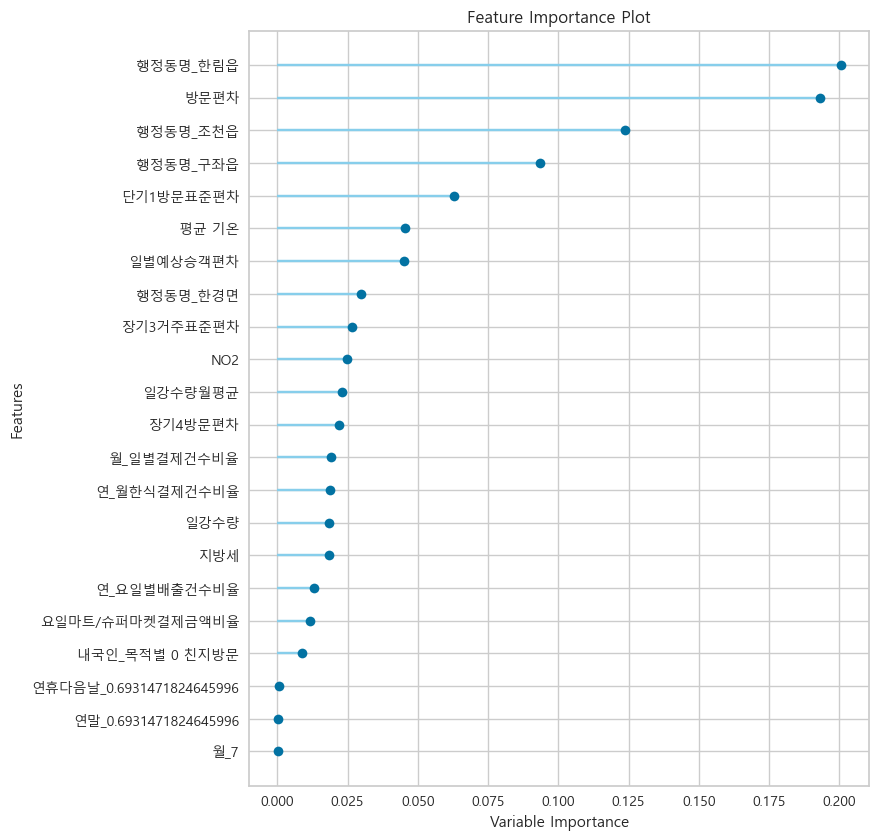

In [22]:
# 피쳐 중요도 확인

plot_model(final_02, 'feature_all' )

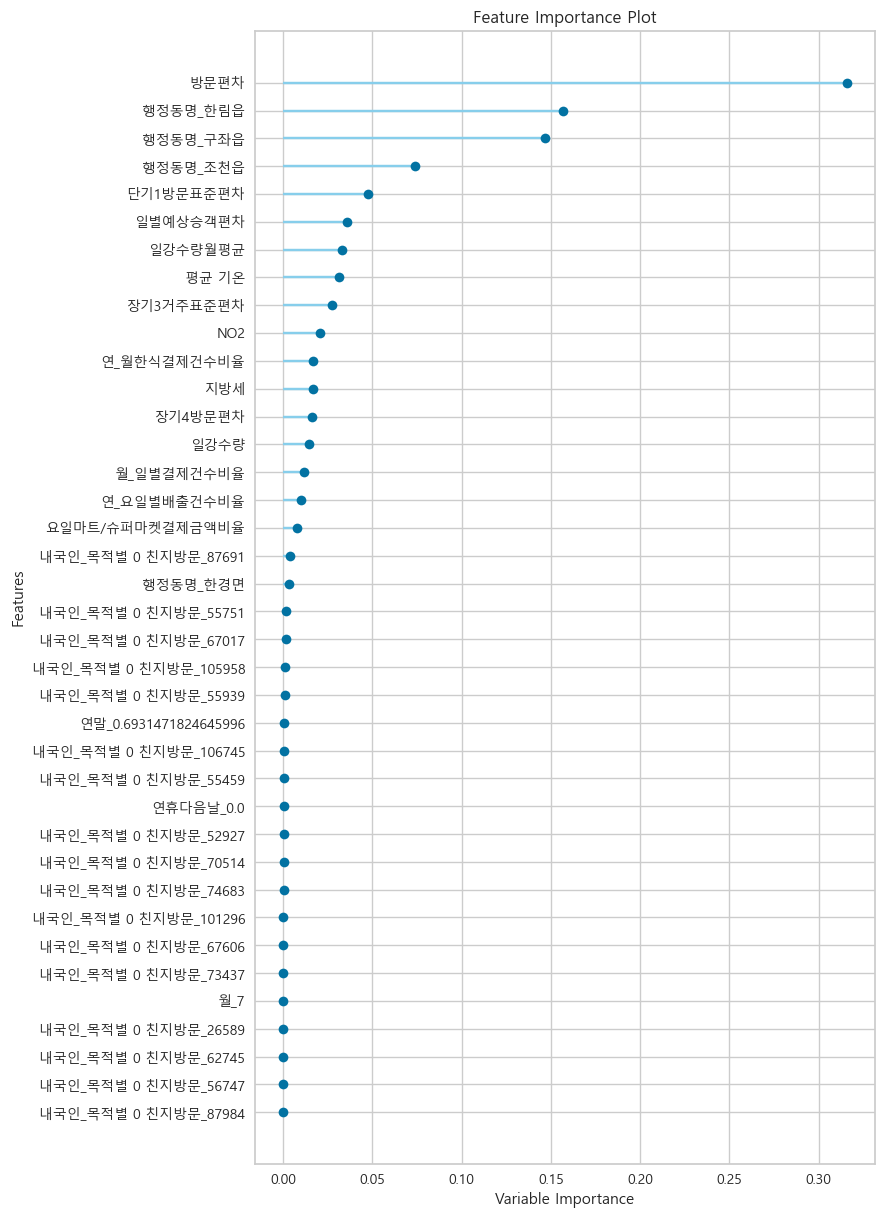

In [87]:
# 피쳐 중요도 확인

plot_model(final_01, 'feature_all' )

In [111]:


# 잔차
plot_model(final_03,"residuals" )

# q-q-plot
plot_model(final_03,"residuals_interactive")

    'data': [{'hovertemplate': 'Split=train<br>Predictions…